In [20]:
# Set to false if working on local env
onColab = True

model_path = './baseline'

# Decide batch size and validation split
batch_size = 128
validation_split = 0.2
test_split = 0.05
epochs = 200

dataset_path = './Training.csv'

window = 300
stride = 20
# 864 / 16
telescope = 54

In [21]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/ANN/CHALLENGE2
baseline.ipynb	model.png  Training.csv


In [22]:
#@title Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [23]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [24]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


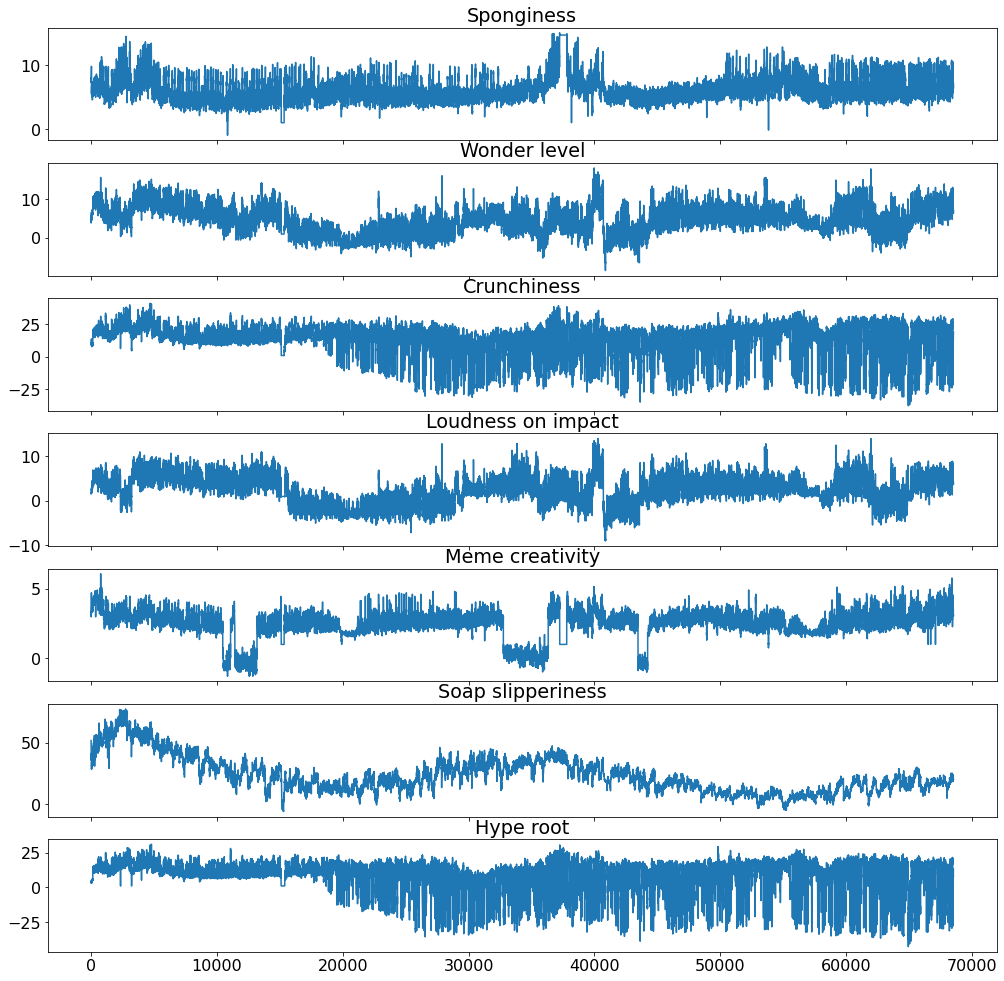

In [26]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

In [27]:
test_size = round(dataset.shape[0] * test_split)
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)


(65102, 7) (3426, 7)


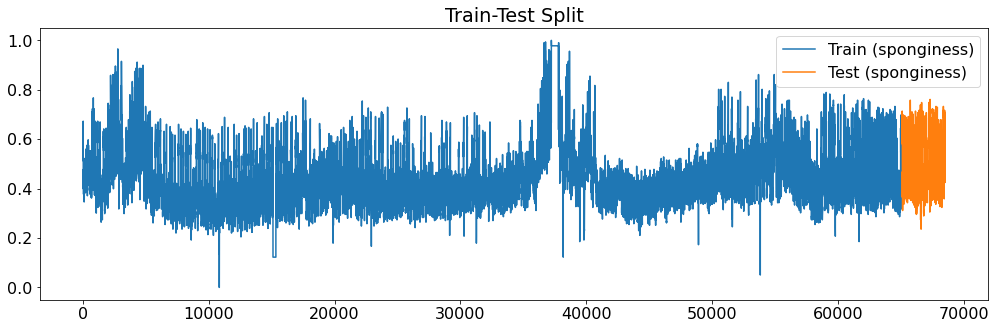

In [28]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [29]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 300, 7)

In [30]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [31]:
target_labels = dataset.columns

In [32]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3253, 300, 7), (3253, 54, 7), (163, 300, 7), (163, 54, 7))

In [33]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

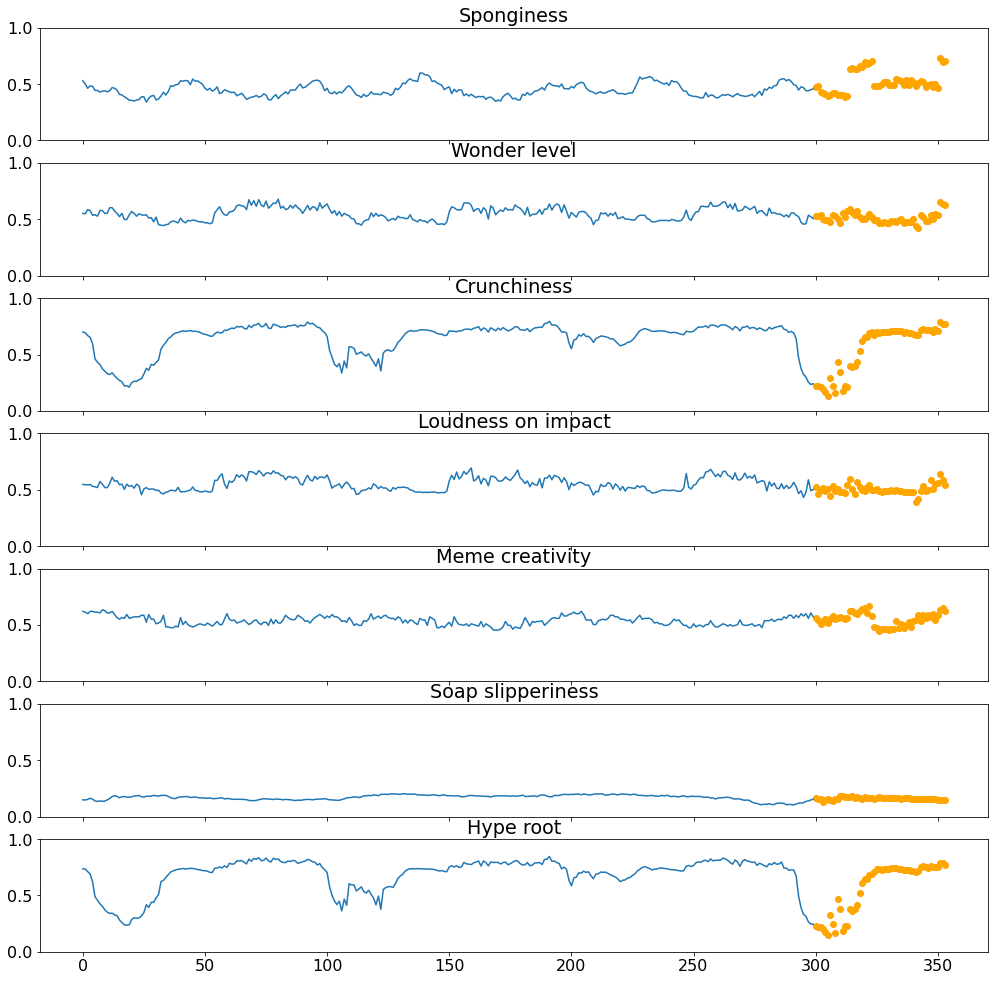

In [34]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [35]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
input_shape, output_shape

((300, 7), (54, 7))

In [36]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 300, 7)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 128)         36864     
 nal)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 300, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 150, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 150, 256)         263168    
 nal)                                                            
                                                             

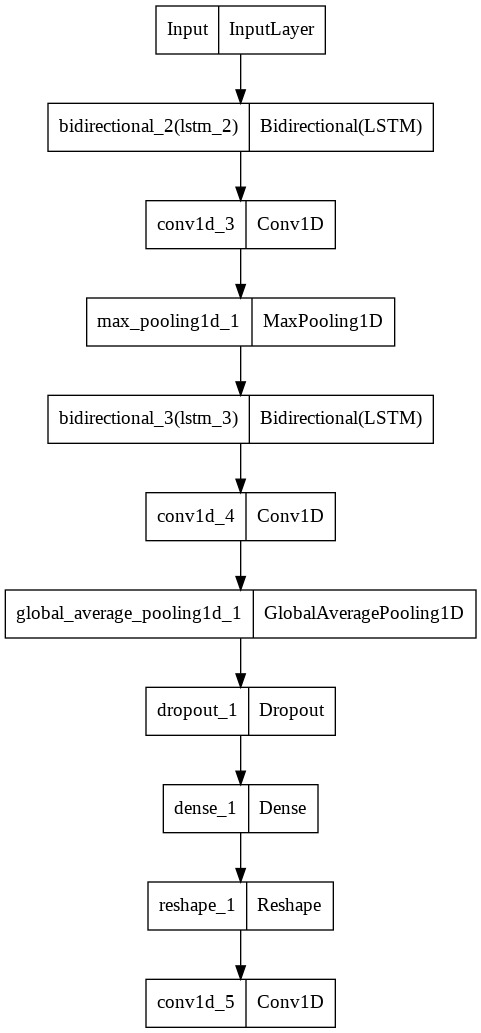

In [37]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [38]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/200
21/21 [==============================] - ETA: 0s - loss: 0.1324 - mae: 0.2998

21/21 [==============================] - 46s 2s/step - loss: 0.1324 - mae: 0.2998 - val_loss: 0.0699 - val_mae: 0.2326 - lr: 0.0010
Epoch 2/200
21/21 [==============================] - ETA: 0s - loss: 0.0497 - mae: 0.1815

21/21 [==============================] - 37s 2s/step - loss: 0.0497 - mae: 0.1815 - val_loss: 0.0518 - val_mae: 0.1987 - lr: 0.0010
Epoch 3/200
21/21 [==============================] - ETA: 0s - loss: 0.0337 - mae: 0.1469

21/21 [==============================] - 38s 2s/step - loss: 0.0337 - mae: 0.1469 - val_loss: 0.0395 - val_mae: 0.1679 - lr: 0.0010
Epoch 4/200
21/21 [==============================] - ETA: 0s - loss: 0.0263 - mae: 0.1276

21/21 [==============================] - 38s 2s/step - loss: 0.0263 - mae: 0.1276 - val_loss: 0.0312 - val_mae: 0.1393 - lr: 0.0010
Epoch 5/200
21/21 [==============================] - ETA: 0s - loss: 0.0222 - mae: 0.1159

21/21 [==============================] - 38s 2s/step - loss: 0.0222 - mae: 0.1159 - val_loss: 0.0265 - val_mae: 0.1243 - lr: 0.0010
Epoch 6/200
21/21 [==============================] - ETA: 0s - loss: 0.0202 - mae: 0.1104

21/21 [==============================] - 37s 2s/step - loss: 0.0202 - mae: 0.1104 - val_loss: 0.0242 - val_mae: 0.1247 - lr: 0.0010
Epoch 7/200
21/21 [==============================] - ETA: 0s - loss: 0.0190 - mae: 0.1069

21/21 [==============================] - 38s 2s/step - loss: 0.0190 - mae: 0.1069 - val_loss: 0.0220 - val_mae: 0.1124 - lr: 0.0010
Epoch 8/200
21/21 [==============================] - ETA: 0s - loss: 0.0179 - mae: 0.1033

21/21 [==============================] - 38s 2s/step - loss: 0.0179 - mae: 0.1033 - val_loss: 0.0211 - val_mae: 0.1080 - lr: 0.0010
Epoch 9/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0176 - mae: 0.1024 - val_loss: 0.0216 - val_mae: 0.1171 - lr: 0.0010
Epoch 10/200
21/21 [==============================] - ETA: 0s - loss: 0.0173 - mae: 0.1017

21/21 [==============================] - 38s 2s/step - loss: 0.0173 - mae: 0.1017 - val_loss: 0.0204 - val_mae: 0.1112 - lr: 0.0010
Epoch 11/200
21/21 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.1008

21/21 [==============================] - 38s 2s/step - loss: 0.0170 - mae: 0.1008 - val_loss: 0.0198 - val_mae: 0.1056 - lr: 0.0010
Epoch 12/200
21/21 [==============================] - ETA: 0s - loss: 0.0167 - mae: 0.0996

21/21 [==============================] - 38s 2s/step - loss: 0.0167 - mae: 0.0996 - val_loss: 0.0196 - val_mae: 0.1055 - lr: 0.0010
Epoch 13/200
21/21 [==============================] - ETA: 0s - loss: 0.0163 - mae: 0.0985

21/21 [==============================] - 38s 2s/step - loss: 0.0163 - mae: 0.0985 - val_loss: 0.0195 - val_mae: 0.1054 - lr: 0.0010
Epoch 14/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0163 - mae: 0.0984 - val_loss: 0.0197 - val_mae: 0.1061 - lr: 0.0010
Epoch 15/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0162 - mae: 0.0980 - val_loss: 0.0197 - val_mae: 0.1082 - lr: 0.0010
Epoch 16/200
21/21 [==============================] - ETA: 0s - loss: 0.0160 - mae: 0.0974

21/21 [==============================] - 37s 2s/step - loss: 0.0160 - mae: 0.0974 - val_loss: 0.0193 - val_mae: 0.1033 - lr: 0.0010
Epoch 17/200
21/21 [==============================] - ETA: 0s - loss: 0.0158 - mae: 0.0965

21/21 [==============================] - 38s 2s/step - loss: 0.0158 - mae: 0.0965 - val_loss: 0.0189 - val_mae: 0.1016 - lr: 0.0010
Epoch 18/200
21/21 [==============================] - 7s 330ms/step - loss: 0.0155 - mae: 0.0957 - val_loss: 0.0190 - val_mae: 0.1015 - lr: 0.0010
Epoch 19/200
21/21 [==============================] - ETA: 0s - loss: 0.0152 - mae: 0.0945

21/21 [==============================] - 38s 2s/step - loss: 0.0152 - mae: 0.0945 - val_loss: 0.0188 - val_mae: 0.1032 - lr: 0.0010
Epoch 20/200
21/21 [==============================] - ETA: 0s - loss: 0.0152 - mae: 0.0947

21/21 [==============================] - 38s 2s/step - loss: 0.0152 - mae: 0.0947 - val_loss: 0.0186 - val_mae: 0.1004 - lr: 0.0010
Epoch 21/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0152 - mae: 0.0945 - val_loss: 0.0190 - val_mae: 0.1055 - lr: 0.0010
Epoch 22/200
21/21 [==============================] - ETA: 0s - loss: 0.0151 - mae: 0.0937

21/21 [==============================] - 38s 2s/step - loss: 0.0151 - mae: 0.0937 - val_loss: 0.0186 - val_mae: 0.1023 - lr: 0.0010
Epoch 23/200
21/21 [==============================] - ETA: 0s - loss: 0.0149 - mae: 0.0934

21/21 [==============================] - 38s 2s/step - loss: 0.0149 - mae: 0.0934 - val_loss: 0.0183 - val_mae: 0.1013 - lr: 0.0010
Epoch 24/200
21/21 [==============================] - ETA: 0s - loss: 0.0148 - mae: 0.0931

21/21 [==============================] - 38s 2s/step - loss: 0.0148 - mae: 0.0931 - val_loss: 0.0181 - val_mae: 0.1003 - lr: 0.0010
Epoch 25/200
21/21 [==============================] - ETA: 0s - loss: 0.0147 - mae: 0.0926

21/21 [==============================] - 38s 2s/step - loss: 0.0147 - mae: 0.0926 - val_loss: 0.0181 - val_mae: 0.0974 - lr: 0.0010
Epoch 26/200
21/21 [==============================] - ETA: 0s - loss: 0.0145 - mae: 0.0921

21/21 [==============================] - 38s 2s/step - loss: 0.0145 - mae: 0.0921 - val_loss: 0.0176 - val_mae: 0.0979 - lr: 0.0010
Epoch 27/200
21/21 [==============================] - ETA: 0s - loss: 0.0142 - mae: 0.0908

21/21 [==============================] - 38s 2s/step - loss: 0.0142 - mae: 0.0908 - val_loss: 0.0175 - val_mae: 0.0964 - lr: 0.0010
Epoch 28/200
21/21 [==============================] - 7s 329ms/step - loss: 0.0144 - mae: 0.0914 - val_loss: 0.0183 - val_mae: 0.1013 - lr: 0.0010
Epoch 29/200
21/21 [==============================] - ETA: 0s - loss: 0.0140 - mae: 0.0899

21/21 [==============================] - 37s 2s/step - loss: 0.0140 - mae: 0.0899 - val_loss: 0.0174 - val_mae: 0.0957 - lr: 0.0010
Epoch 30/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0138 - mae: 0.0892 - val_loss: 0.0175 - val_mae: 0.0969 - lr: 0.0010
Epoch 31/200
21/21 [==============================] - ETA: 0s - loss: 0.0137 - mae: 0.0891

21/21 [==============================] - 38s 2s/step - loss: 0.0137 - mae: 0.0891 - val_loss: 0.0173 - val_mae: 0.0953 - lr: 0.0010
Epoch 32/200
21/21 [==============================] - ETA: 0s - loss: 0.0134 - mae: 0.0879

21/21 [==============================] - 38s 2s/step - loss: 0.0134 - mae: 0.0879 - val_loss: 0.0169 - val_mae: 0.0943 - lr: 0.0010
Epoch 33/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0135 - mae: 0.0880 - val_loss: 0.0169 - val_mae: 0.0935 - lr: 0.0010
Epoch 34/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0134 - mae: 0.0880 - val_loss: 0.0172 - val_mae: 0.0973 - lr: 0.0010
Epoch 35/200
21/21 [==============================] - ETA: 0s - loss: 0.0131 - mae: 0.0866

21/21 [==============================] - 38s 2s/step - loss: 0.0131 - mae: 0.0866 - val_loss: 0.0165 - val_mae: 0.0929 - lr: 0.0010
Epoch 36/200
21/21 [==============================] - ETA: 0s - loss: 0.0130 - mae: 0.0864

21/21 [==============================] - 37s 2s/step - loss: 0.0130 - mae: 0.0864 - val_loss: 0.0163 - val_mae: 0.0920 - lr: 0.0010
Epoch 37/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0129 - mae: 0.0859 - val_loss: 0.0166 - val_mae: 0.0933 - lr: 0.0010
Epoch 38/200
21/21 [==============================] - ETA: 0s - loss: 0.0129 - mae: 0.0861

21/21 [==============================] - 38s 2s/step - loss: 0.0129 - mae: 0.0861 - val_loss: 0.0163 - val_mae: 0.0929 - lr: 0.0010
Epoch 39/200
21/21 [==============================] - ETA: 0s - loss: 0.0127 - mae: 0.0852

21/21 [==============================] - 38s 2s/step - loss: 0.0127 - mae: 0.0852 - val_loss: 0.0162 - val_mae: 0.0910 - lr: 0.0010
Epoch 40/200
21/21 [==============================] - 7s 327ms/step - loss: 0.0126 - mae: 0.0846 - val_loss: 0.0166 - val_mae: 0.0933 - lr: 0.0010
Epoch 41/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0125 - mae: 0.0844 - val_loss: 0.0164 - val_mae: 0.0949 - lr: 0.0010
Epoch 42/200
21/21 [==============================] - ETA: 0s - loss: 0.0123 - mae: 0.0834

21/21 [==============================] - 38s 2s/step - loss: 0.0123 - mae: 0.0834 - val_loss: 0.0161 - val_mae: 0.0912 - lr: 5.0000e-04
Epoch 43/200
21/21 [==============================] - 7s 330ms/step - loss: 0.0121 - mae: 0.0829 - val_loss: 0.0161 - val_mae: 0.0929 - lr: 5.0000e-04
Epoch 44/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0121 - mae: 0.0827 - val_loss: 0.0162 - val_mae: 0.0934 - lr: 5.0000e-04
Epoch 45/200
21/21 [==============================] - ETA: 0s - loss: 0.0121 - mae: 0.0827

21/21 [==============================] - 38s 2s/step - loss: 0.0121 - mae: 0.0827 - val_loss: 0.0160 - val_mae: 0.0917 - lr: 5.0000e-04
Epoch 46/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0120 - mae: 0.0822 - val_loss: 0.0160 - val_mae: 0.0919 - lr: 5.0000e-04
Epoch 47/200
21/21 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.0823

21/21 [==============================] - 38s 2s/step - loss: 0.0119 - mae: 0.0823 - val_loss: 0.0159 - val_mae: 0.0919 - lr: 5.0000e-04
Epoch 48/200
21/21 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.0823

21/21 [==============================] - 38s 2s/step - loss: 0.0119 - mae: 0.0823 - val_loss: 0.0158 - val_mae: 0.0901 - lr: 5.0000e-04
Epoch 49/200
21/21 [==============================] - ETA: 0s - loss: 0.0118 - mae: 0.0817

21/21 [==============================] - 38s 2s/step - loss: 0.0118 - mae: 0.0817 - val_loss: 0.0157 - val_mae: 0.0907 - lr: 5.0000e-04
Epoch 50/200
21/21 [==============================] - ETA: 0s - loss: 0.0117 - mae: 0.0814

21/21 [==============================] - 38s 2s/step - loss: 0.0117 - mae: 0.0814 - val_loss: 0.0154 - val_mae: 0.0895 - lr: 5.0000e-04
Epoch 51/200
21/21 [==============================] - ETA: 0s - loss: 0.0115 - mae: 0.0805

21/21 [==============================] - 38s 2s/step - loss: 0.0115 - mae: 0.0805 - val_loss: 0.0153 - val_mae: 0.0914 - lr: 5.0000e-04
Epoch 52/200
21/21 [==============================] - ETA: 0s - loss: 0.0113 - mae: 0.0799

21/21 [==============================] - 38s 2s/step - loss: 0.0113 - mae: 0.0799 - val_loss: 0.0146 - val_mae: 0.0880 - lr: 5.0000e-04
Epoch 53/200
21/21 [==============================] - ETA: 0s - loss: 0.0110 - mae: 0.0791

21/21 [==============================] - 38s 2s/step - loss: 0.0110 - mae: 0.0791 - val_loss: 0.0142 - val_mae: 0.0868 - lr: 5.0000e-04
Epoch 54/200
21/21 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0780

21/21 [==============================] - 38s 2s/step - loss: 0.0106 - mae: 0.0780 - val_loss: 0.0134 - val_mae: 0.0846 - lr: 5.0000e-04
Epoch 55/200
21/21 [==============================] - ETA: 0s - loss: 0.0104 - mae: 0.0772

21/21 [==============================] - 38s 2s/step - loss: 0.0104 - mae: 0.0772 - val_loss: 0.0128 - val_mae: 0.0832 - lr: 5.0000e-04
Epoch 56/200
21/21 [==============================] - ETA: 0s - loss: 0.0101 - mae: 0.0761

21/21 [==============================] - 37s 2s/step - loss: 0.0101 - mae: 0.0761 - val_loss: 0.0125 - val_mae: 0.0816 - lr: 5.0000e-04
Epoch 57/200
21/21 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0753

21/21 [==============================] - 38s 2s/step - loss: 0.0099 - mae: 0.0753 - val_loss: 0.0123 - val_mae: 0.0812 - lr: 5.0000e-04
Epoch 58/200
21/21 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0751

21/21 [==============================] - 37s 2s/step - loss: 0.0099 - mae: 0.0751 - val_loss: 0.0122 - val_mae: 0.0827 - lr: 5.0000e-04
Epoch 59/200
21/21 [==============================] - ETA: 0s - loss: 0.0097 - mae: 0.0746

21/21 [==============================] - 37s 2s/step - loss: 0.0097 - mae: 0.0746 - val_loss: 0.0121 - val_mae: 0.0817 - lr: 5.0000e-04
Epoch 60/200
21/21 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0743

21/21 [==============================] - 38s 2s/step - loss: 0.0096 - mae: 0.0743 - val_loss: 0.0120 - val_mae: 0.0802 - lr: 5.0000e-04
Epoch 61/200
21/21 [==============================] - 7s 329ms/step - loss: 0.0093 - mae: 0.0728 - val_loss: 0.0124 - val_mae: 0.0833 - lr: 5.0000e-04
Epoch 62/200
21/21 [==============================] - 7s 328ms/step - loss: 0.0094 - mae: 0.0733 - val_loss: 0.0121 - val_mae: 0.0814 - lr: 5.0000e-04
Epoch 63/200
21/21 [==============================] - ETA: 0s - loss: 0.0092 - mae: 0.0724

21/21 [==============================] - 38s 2s/step - loss: 0.0092 - mae: 0.0724 - val_loss: 0.0116 - val_mae: 0.0796 - lr: 5.0000e-04
Epoch 64/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0091 - mae: 0.0719 - val_loss: 0.0121 - val_mae: 0.0809 - lr: 5.0000e-04
Epoch 65/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0090 - mae: 0.0713 - val_loss: 0.0117 - val_mae: 0.0804 - lr: 5.0000e-04
Epoch 66/200
21/21 [==============================] - ETA: 0s - loss: 0.0091 - mae: 0.0719

21/21 [==============================] - 37s 2s/step - loss: 0.0091 - mae: 0.0719 - val_loss: 0.0115 - val_mae: 0.0785 - lr: 5.0000e-04
Epoch 67/200
21/21 [==============================] - ETA: 0s - loss: 0.0087 - mae: 0.0702

21/21 [==============================] - 38s 2s/step - loss: 0.0087 - mae: 0.0702 - val_loss: 0.0112 - val_mae: 0.0780 - lr: 5.0000e-04
Epoch 68/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0087 - mae: 0.0701 - val_loss: 0.0113 - val_mae: 0.0787 - lr: 5.0000e-04
Epoch 69/200
21/21 [==============================] - ETA: 0s - loss: 0.0085 - mae: 0.0693

21/21 [==============================] - 38s 2s/step - loss: 0.0085 - mae: 0.0693 - val_loss: 0.0107 - val_mae: 0.0748 - lr: 5.0000e-04
Epoch 70/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0084 - mae: 0.0693 - val_loss: 0.0124 - val_mae: 0.0839 - lr: 5.0000e-04
Epoch 71/200
21/21 [==============================] - 7s 330ms/step - loss: 0.0084 - mae: 0.0689 - val_loss: 0.0109 - val_mae: 0.0776 - lr: 5.0000e-04
Epoch 72/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0084 - mae: 0.0690 - val_loss: 0.0114 - val_mae: 0.0787 - lr: 5.0000e-04
Epoch 73/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0083 - mae: 0.0685 - val_loss: 0.0107 - val_mae: 0.0759 - lr: 5.0000e-04
Epoch 74/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0081 - mae: 0.0675 - val_loss: 0.0108 - val_mae: 0.0769 - lr: 5.0000e-04
Epoch 75/200
21/21 [==============================] - ETA: 0s - loss: 0.0079 - mae: 0.0668

21/21 [==============================] - 38s 2s/step - loss: 0.0079 - mae: 0.0668 - val_loss: 0.0104 - val_mae: 0.0743 - lr: 2.5000e-04
Epoch 76/200
21/21 [==============================] - 7s 330ms/step - loss: 0.0078 - mae: 0.0662 - val_loss: 0.0110 - val_mae: 0.0775 - lr: 2.5000e-04
Epoch 77/200
21/21 [==============================] - ETA: 0s - loss: 0.0078 - mae: 0.0664

21/21 [==============================] - 37s 2s/step - loss: 0.0078 - mae: 0.0664 - val_loss: 0.0103 - val_mae: 0.0746 - lr: 2.5000e-04
Epoch 78/200
21/21 [==============================] - 7s 327ms/step - loss: 0.0077 - mae: 0.0658 - val_loss: 0.0104 - val_mae: 0.0738 - lr: 2.5000e-04
Epoch 79/200
21/21 [==============================] - 7s 328ms/step - loss: 0.0077 - mae: 0.0659 - val_loss: 0.0107 - val_mae: 0.0755 - lr: 2.5000e-04
Epoch 80/200
21/21 [==============================] - 7s 327ms/step - loss: 0.0077 - mae: 0.0659 - val_loss: 0.0104 - val_mae: 0.0754 - lr: 2.5000e-04
Epoch 81/200
21/21 [==============================] - ETA: 0s - loss: 0.0075 - mae: 0.0649

21/21 [==============================] - 38s 2s/step - loss: 0.0075 - mae: 0.0649 - val_loss: 0.0103 - val_mae: 0.0734 - lr: 1.2500e-04
Epoch 82/200
21/21 [==============================] - ETA: 0s - loss: 0.0075 - mae: 0.0650

21/21 [==============================] - 38s 2s/step - loss: 0.0075 - mae: 0.0650 - val_loss: 0.0103 - val_mae: 0.0748 - lr: 1.2500e-04
Epoch 83/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0075 - mae: 0.0648 - val_loss: 0.0104 - val_mae: 0.0751 - lr: 1.2500e-04
Epoch 84/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0074 - mae: 0.0645 - val_loss: 0.0103 - val_mae: 0.0747 - lr: 1.2500e-04
Epoch 85/200
21/21 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0645

21/21 [==============================] - 38s 2s/step - loss: 0.0074 - mae: 0.0645 - val_loss: 0.0101 - val_mae: 0.0735 - lr: 1.2500e-04
Epoch 86/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0074 - mae: 0.0641 - val_loss: 0.0101 - val_mae: 0.0738 - lr: 1.2500e-04
Epoch 87/200
21/21 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0644

21/21 [==============================] - 37s 2s/step - loss: 0.0074 - mae: 0.0644 - val_loss: 0.0100 - val_mae: 0.0728 - lr: 1.2500e-04
Epoch 88/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0074 - mae: 0.0644 - val_loss: 0.0100 - val_mae: 0.0731 - lr: 1.2500e-04
Epoch 89/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0073 - mae: 0.0637 - val_loss: 0.0100 - val_mae: 0.0738 - lr: 1.2500e-04
Epoch 90/200
21/21 [==============================] - ETA: 0s - loss: 0.0073 - mae: 0.0641

21/21 [==============================] - 38s 2s/step - loss: 0.0073 - mae: 0.0641 - val_loss: 0.0100 - val_mae: 0.0736 - lr: 1.2500e-04
Epoch 91/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0073 - mae: 0.0639 - val_loss: 0.0100 - val_mae: 0.0736 - lr: 1.2500e-04
Epoch 92/200
21/21 [==============================] - 7s 329ms/step - loss: 0.0072 - mae: 0.0636 - val_loss: 0.0100 - val_mae: 0.0733 - lr: 1.2500e-04
Epoch 93/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0073 - mae: 0.0641 - val_loss: 0.0101 - val_mae: 0.0739 - lr: 6.2500e-05
Epoch 94/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0072 - mae: 0.0636 - val_loss: 0.0100 - val_mae: 0.0734 - lr: 6.2500e-05
Epoch 95/200
21/21 [==============================] - ETA: 0s - loss: 0.0072 - mae: 0.0634

21/21 [==============================] - 38s 2s/step - loss: 0.0072 - mae: 0.0634 - val_loss: 0.0099 - val_mae: 0.0732 - lr: 6.2500e-05
Epoch 96/200
21/21 [==============================] - ETA: 0s - loss: 0.0072 - mae: 0.0631

21/21 [==============================] - 38s 2s/step - loss: 0.0072 - mae: 0.0631 - val_loss: 0.0099 - val_mae: 0.0730 - lr: 6.2500e-05
Epoch 97/200
21/21 [==============================] - ETA: 0s - loss: 0.0072 - mae: 0.0632

21/21 [==============================] - 38s 2s/step - loss: 0.0072 - mae: 0.0632 - val_loss: 0.0098 - val_mae: 0.0724 - lr: 6.2500e-05
Epoch 98/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0071 - mae: 0.0631 - val_loss: 0.0099 - val_mae: 0.0732 - lr: 6.2500e-05
Epoch 99/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0071 - mae: 0.0631 - val_loss: 0.0099 - val_mae: 0.0730 - lr: 6.2500e-05
Epoch 100/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0071 - mae: 0.0632 - val_loss: 0.0099 - val_mae: 0.0727 - lr: 6.2500e-05
Epoch 101/200
21/21 [==============================] - 7s 329ms/step - loss: 0.0071 - mae: 0.0632 - val_loss: 0.0099 - val_mae: 0.0734 - lr: 6.2500e-05
Epoch 102/200
21/21 [==============================] - ETA: 0s - loss: 0.0071 - mae: 0.0628

21/21 [==============================] - 37s 2s/step - loss: 0.0071 - mae: 0.0628 - val_loss: 0.0097 - val_mae: 0.0720 - lr: 6.2500e-05
Epoch 103/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0071 - mae: 0.0630 - val_loss: 0.0098 - val_mae: 0.0725 - lr: 3.1250e-05
Epoch 104/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0070 - mae: 0.0627 - val_loss: 0.0098 - val_mae: 0.0727 - lr: 3.1250e-05
Epoch 105/200
21/21 [==============================] - 7s 330ms/step - loss: 0.0070 - mae: 0.0626 - val_loss: 0.0099 - val_mae: 0.0733 - lr: 3.1250e-05
Epoch 106/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0071 - mae: 0.0629 - val_loss: 0.0098 - val_mae: 0.0725 - lr: 3.1250e-05
Epoch 107/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0071 - mae: 0.0628 - val_loss: 0.0097 - val_mae: 0.0726 - lr: 3.1250e-05
Epoch 108/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0070 - mae: 0.0627 - val_

21/21 [==============================] - 37s 2s/step - loss: 0.0071 - mae: 0.0627 - val_loss: 0.0097 - val_mae: 0.0722 - lr: 1.5625e-05
Epoch 113/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0070 - mae: 0.0626 - val_loss: 0.0097 - val_mae: 0.0725 - lr: 1.0000e-05
Epoch 114/200
21/21 [==============================] - 7s 333ms/step - loss: 0.0070 - mae: 0.0625 - val_loss: 0.0097 - val_mae: 0.0725 - lr: 1.0000e-05
Epoch 115/200
21/21 [==============================] - ETA: 0s - loss: 0.0070 - mae: 0.0627

21/21 [==============================] - 38s 2s/step - loss: 0.0070 - mae: 0.0627 - val_loss: 0.0097 - val_mae: 0.0721 - lr: 1.0000e-05
Epoch 116/200
21/21 [==============================] - 7s 330ms/step - loss: 0.0069 - mae: 0.0623 - val_loss: 0.0097 - val_mae: 0.0720 - lr: 1.0000e-05
Epoch 117/200
21/21 [==============================] - 7s 329ms/step - loss: 0.0070 - mae: 0.0623 - val_loss: 0.0097 - val_mae: 0.0726 - lr: 1.0000e-05
Epoch 118/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0070 - mae: 0.0628 - val_loss: 0.0097 - val_mae: 0.0722 - lr: 1.0000e-05
Epoch 119/200
21/21 [==============================] - 7s 332ms/step - loss: 0.0070 - mae: 0.0624 - val_loss: 0.0097 - val_mae: 0.0725 - lr: 1.0000e-05
Epoch 120/200
21/21 [==============================] - 7s 331ms/step - loss: 0.0070 - mae: 0.0624 - val_loss: 0.0097 - val_mae: 0.0722 - lr: 1.0000e-05
Epoch 121/200
21/21 [==============================] - 7s 329ms/step - loss: 0.0070 - mae: 0.0624 - val_

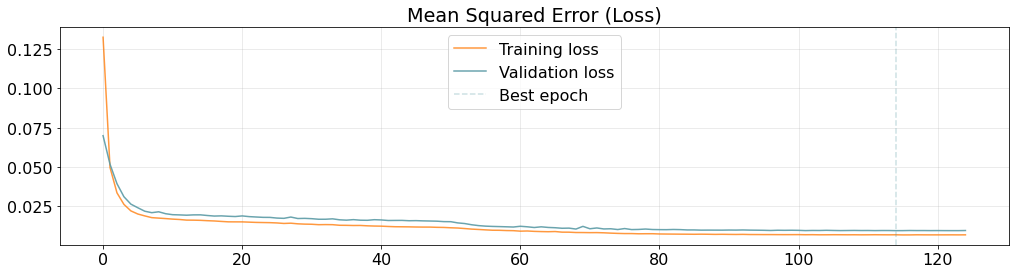

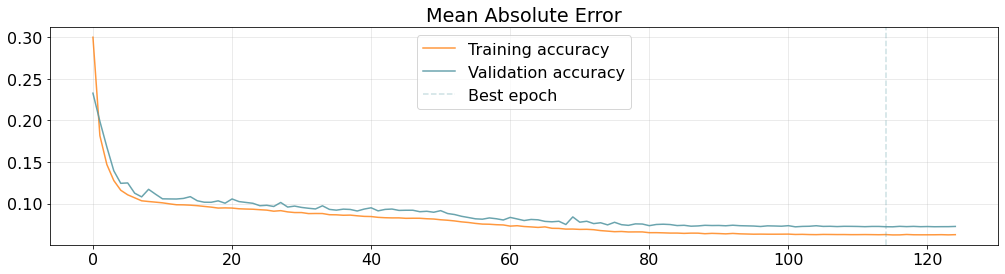

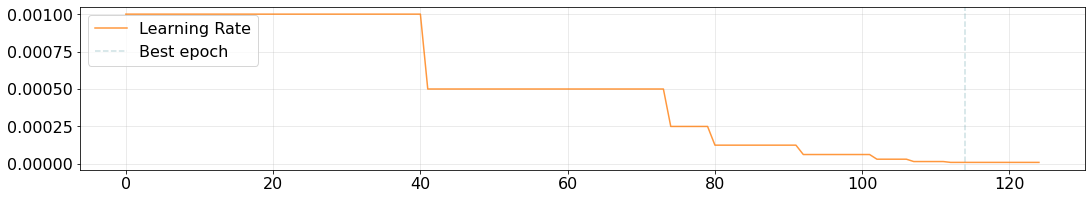

In [39]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [40]:
model.save(model_path)

In [41]:
model = tfk.models.load_model(model_path)

In [42]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(163, 54, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.008326309>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06452222>)

In [43]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

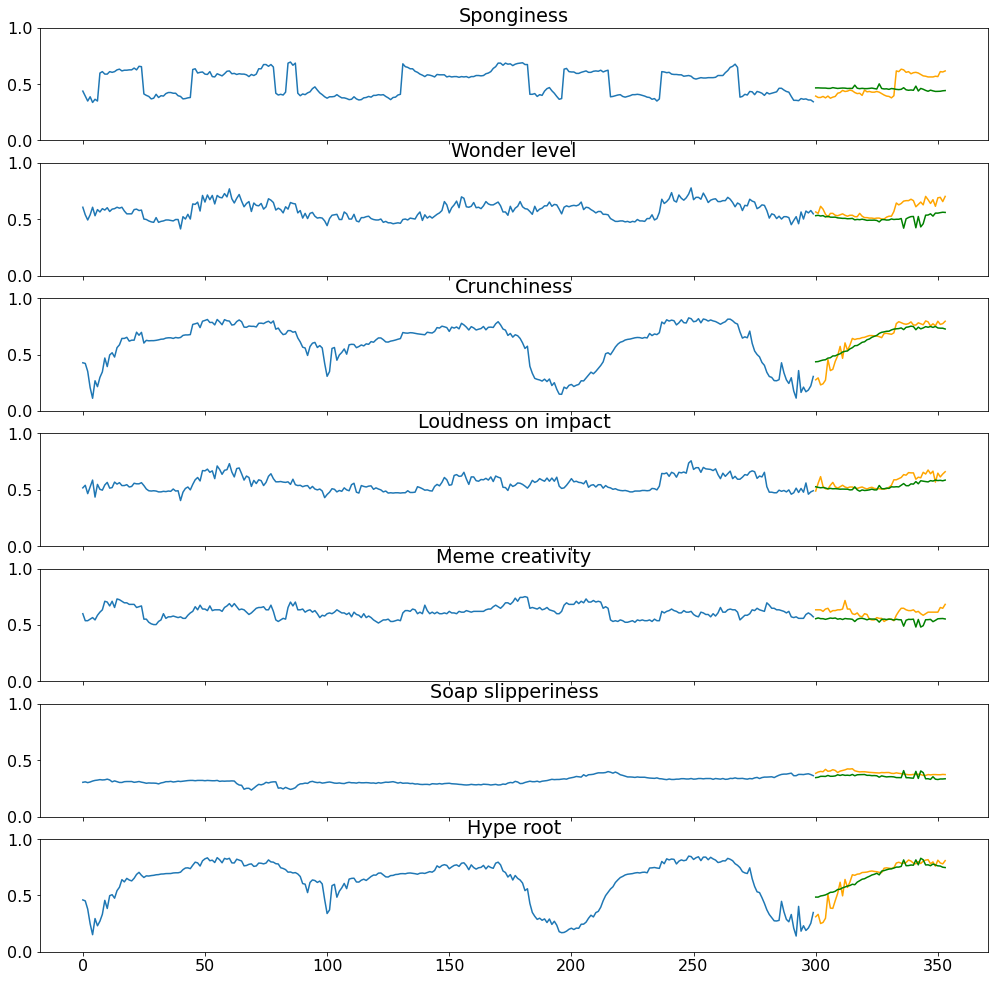

In [44]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [45]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [46]:
future_predictions = model.predict(future)

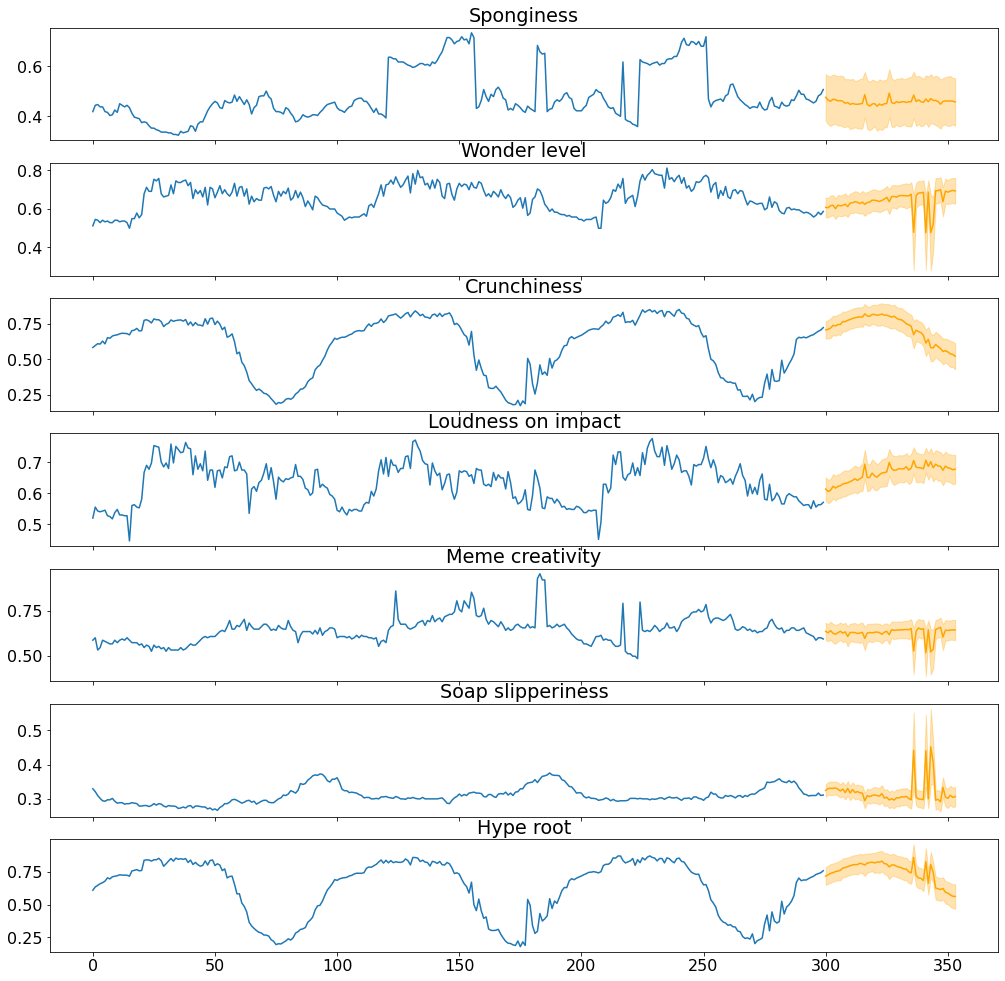

In [47]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [48]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((122, 300, 7), (122, 864, 7))

In [49]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [50]:
reg_predictions.shape

(122, 864, 7)

In [51]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.010449154>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.075890906>)

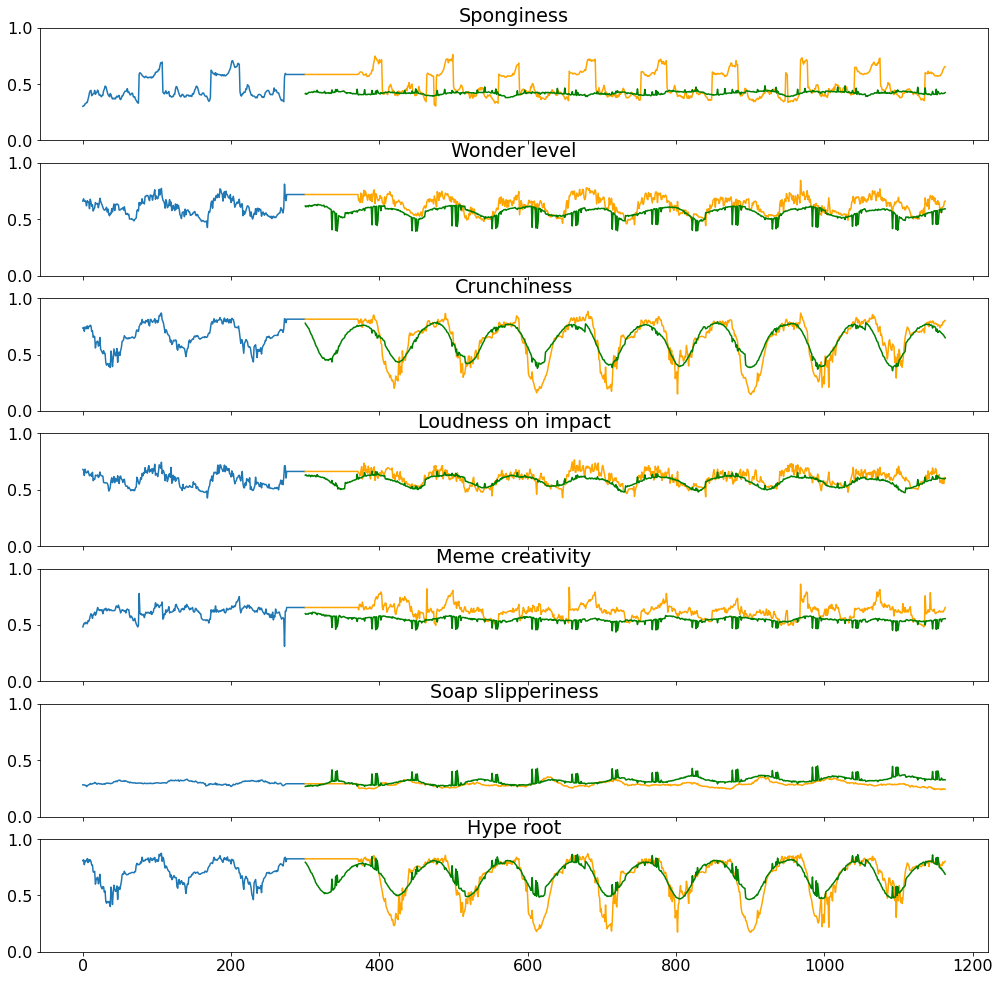

In [52]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)